In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import os
import pickle
from scipy.optimize import minimize
import spin_package.ising_fixed_T as ising_T
import spin_package.utils as sp_utils

%load_ext autoreload
%autoreload 2

## State Following Fixed Temperatures

In [2]:
p = 3
n_points_m = 100
n_points_less_T = 1
n_points_T = 2
n_points_more_T = 0

T_kauz, T_dyn = sp_utils.get_Tk_Td(p, model="ising")

Teqs = np.hstack(
    (
        (T_kauz - (T_dyn - T_kauz) / (n_points_T) * np.arange(1, n_points_less_T + 1))[::-1],
        np.linspace(T_kauz, T_dyn, n_points_T + 1),
        T_dyn + (T_dyn - T_kauz) / (n_points_T) * np.arange(1, n_points_more_T + 1),
    )
)
T_planting = T_kauz
J0 = 0.5 / T_planting

m2i = 0.9
q2i = 0.9

In [3]:
ms = np.linspace(0.0, 0.9, n_points_m)
q_old = 0.9
all_data = {}

for jdx, T in enumerate(tqdm(Teqs, desc="RS")):
    data = sp_utils.observables(["q", "m", "f", "h"], (n_points_m,))
    total_file_name = "../data/ising/" + sp_utils.get_file_name_T_sweep_m(
        "ising", p, T_planting, T, ms
    )
    if os.path.exists(total_file_name):
        with open(total_file_name, "rb") as f:
            data = pickle.load(f)
    else:
        for idx, m in enumerate(tqdm(ms, desc="m", leave=False)):
            h, q = ising_T.fixed_points_h_q_T(m, T, p, J0, blend=0.95, q_init=q_old)

            data["q"][idx] = q
            data["h"][idx] = h
            data["m"][idx] = m
            data["f"][idx] = ising_T.f_FP_T(m, q, h, p, T, J0)

            q_old = q

        with open(total_file_name, "wb") as f:
            pickle.dump(data, f)

    all_data[T] = data

print("Data is saved.")

RS:   0%|          | 0/4 [00:00<?, ?it/s]

m:   0%|          | 0/100 [00:00<?, ?it/s]

m:   0%|          | 0/100 [00:00<?, ?it/s]

m:   0%|          | 0/100 [00:00<?, ?it/s]

m:   0%|          | 0/100 [00:00<?, ?it/s]

Data is saved.


In [4]:
m0, q0, h0 = 0.9, 0.9, 0.9
blend = 0.1
total_file_name = "../data/ising/" + sp_utils.get_file_name_sweep_T(
    "ising", p, T_planting, Teqs, m0, q0
)
if os.path.exists(total_file_name):
    print("Data is already saved.")
    with open(total_file_name, "rb") as f:
        data_fixed_point = pickle.load(f)

    print("Data is loaded.")
else:
    print("Data is not saved.")
    data_fixed_point = sp_utils.observables(["T", "q", "m", "f", "e"], (len(Teqs),))
    for i, T in enumerate(tqdm(Teqs)):
        m, q, h = m0, q0, h0
        err = 1
        while err > 1e-7:
            m_new = ising_T.compute_m_standard(m, q, p, 1 / T, J0)
            q_new = ising_T.compute_q_standard(m, q, p, 1 / T, J0)

            err = max(abs(q_new - q), abs(m_new - m))
            m = blend * m + (1 - blend) * m_new
            q = blend * q + (1 - blend) * q_new

        data_fixed_point["T"][i] = T
        data_fixed_point["m"][i] = m
        data_fixed_point["q"][i] = q
        data_fixed_point["f"][i] = ising_T.compute_free_energy_standard(
            m, q, p, 1 / T, J0
        )
        data_fixed_point["e"][i] = ising_T.compute_energy_standard(m, q, p, 1 / T, J0)

    with open(total_file_name, "wb") as f:
        pickle.dump(data_fixed_point, f)

    print("Data is saved.")

Data is not saved.


  0%|          | 0/4 [00:00<?, ?it/s]

Data is saved.


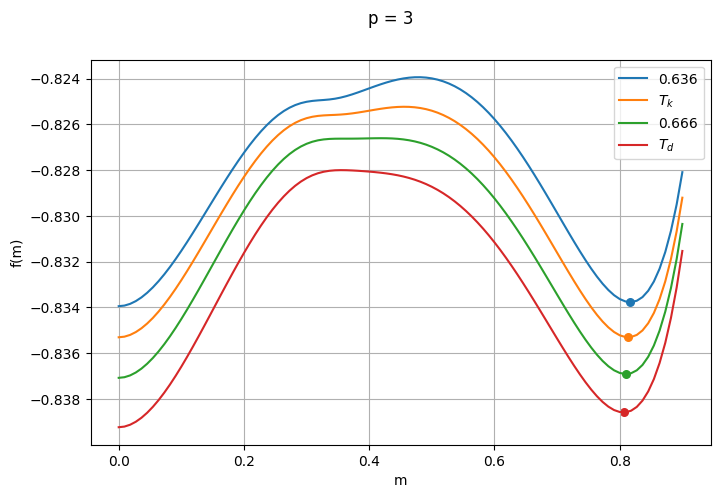

In [5]:
plt.figure(figsize=(8,5))
plt.suptitle(f"p = {p:d}")
for i, T in enumerate(Teqs):
    legend_name = sp_utils.legend_name_Tk_Td_T(T, T_kauz, T_dyn)

    data = all_data[T]
    plt.plot(data['m'], data['f'], label=legend_name, color=f'C{i}')

    plt.scatter(data_fixed_point['m'][i], data_fixed_point['f'][i], color=f'C{i}', marker='o', s=30)

plt.xlabel('m')
plt.ylabel(r'f(m)')
plt.legend()
plt.grid()


## State Following Untill Losing

In [15]:
p = 50
T_kauz, T_dyn = sp_utils.get_Tk_Td(p, model="ising")
T_planting = T_kauz
J0 = 0.5 / T_planting

T_start = T_kauz
deltaT = 1e-5
m0, q0 = 1 - 1 / (10 * p), 1 - 1 / (10 * p)

In [16]:
blend = 0.5
total_file_name = "../data/ising/" + sp_utils.get_file_name_until_fail(
    "ising", p, T_planting, T_start, deltaT, m0, q0
)
if os.path.exists(total_file_name):
    print("Data is already saved.")
    with open(total_file_name, "rb") as f:
        data_fixed_point = pickle.load(f)

    print("Data is loaded.")
else:
    print("Data is not saved.")
    tmp_T, tmp_m, tmp_q, tmp_f, tmp_e = [], [], [], [], []
    cur_T = T_start
    m, q = m0, q0
    idx = 0
    while True:
        if idx % 10_000 == 0:
            print(f"T = {cur_T:.3f}")
            
        err = 1
        while err > 1e-7:
            m_new = ising_T.compute_m_standard(m, q, p, 1 / cur_T, J0)
            q_new = ising_T.compute_q_standard(m, q, p, 1 / cur_T, J0)

            # print(f"new_m = {m_new:.3f}, new_q = {q_new:.3f}", end=", ")
            err = max(abs(q_new - q), abs(m_new - m))
            m = blend * m + (1 - blend) * m_new
            q = blend * q + (1 - blend) * q_new

        if abs(m) < 1e-7:
            break
        else:
            tmp_T.append(cur_T)
            tmp_m.append(m)
            tmp_q.append(q)
            tmp_f.append(ising_T.compute_free_energy_standard(m, q, p, 1 / cur_T, J0))
            tmp_e.append(ising_T.compute_energy_standard(m, q, p, 1 / cur_T, J0))

            cur_T += deltaT

        idx += 1

    print("")
    data_fixed_point = sp_utils.observables(["T", "q", "m", "f", "e"], (len(tmp_T),))
    data_fixed_point["T"] = np.array(tmp_T)
    data_fixed_point["m"] = np.array(tmp_m)
    data_fixed_point["q"] = np.array(tmp_q)
    data_fixed_point["f"] = np.array(tmp_f)
    data_fixed_point["e"] = np.array(tmp_e)

    # with open(total_file_name, "wb") as f:
    #     pickle.dump(data_fixed_point, f)

    print("Data is saved.")

Data is not saved.
T = 0.601
T = 0.701
T = 0.801
T = 0.901
T = 1.001
T = 1.101
T = 1.201
T = 1.301
T = 1.401
T = 1.501
T = 1.601
T = 1.701
T = 1.801
T = 1.901
T = 2.001
T = 2.101
T = 2.201
T = 2.301
T = 2.401
T = 2.501
T = 2.601
T = 2.701
T = 2.801
T = 2.901
T = 3.001
T = 3.101
T = 3.201
T = 3.301
T = 3.401
T = 3.501
T = 3.601
T = 3.701
T = 3.801
T = 3.901
T = 4.001
T = 4.101
T = 4.201
T = 4.301
T = 4.401
T = 4.501
T = 4.601
T = 4.701
T = 4.801
T = 4.901
T = 5.001
T = 5.101
T = 5.201
T = 5.301
T = 5.401
T = 5.501
T = 5.601
T = 5.701
T = 5.801
T = 5.901
T = 6.001
T = 6.101
T = 6.201
T = 6.301
T = 6.401
T = 6.501
T = 6.601
T = 6.701
T = 6.801
T = 6.901
T = 7.001
T = 7.101
T = 7.201
T = 7.301
T = 7.401
T = 7.501
T = 7.601
T = 7.701
T = 7.801
T = 7.901
T = 8.001
T = 8.101
T = 8.201
T = 8.301
T = 8.401
T = 8.501
T = 8.601
T = 8.701
T = 8.801
T = 8.901
T = 9.001
T = 9.101
T = 9.201
T = 9.301
T = 9.401
T = 9.501
T = 9.601
T = 9.701
T = 9.801
T = 9.901
T = 10.001
T = 10.101
T = 10.201
T = 10.3

Text(0, 0.5, 'e')

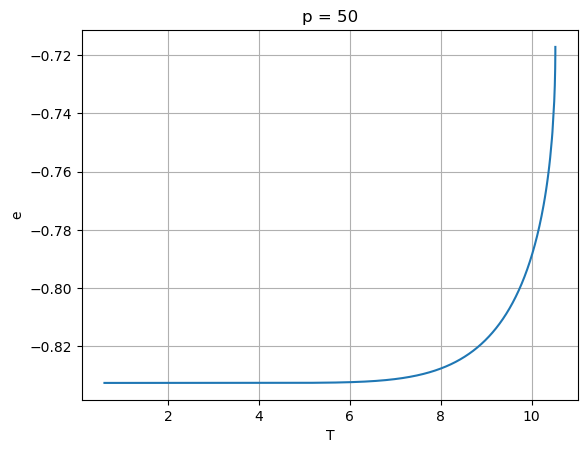

In [17]:
plt.plot(data_fixed_point['T'], data_fixed_point['e'], label='m')
plt.title(f"p = {p:d}")
plt.grid()
plt.xlabel('T')
plt.ylabel('e')
# plt.xscale('log')
# plt.yscale('log')

## $T_d^+(p)$ from State Following

In [2]:
p_tab = np.unique(np.logspace(np.log10(3), 3, 42, dtype=int))
print("p_tab = ", p_tab)

deltaT = 1e-5
blend = 0.5

total_file_name = "../data/ising/" + sp_utils.get_file_name_Tdplus_Tk(
    "ising", deltaT, 1, 1, p_tab[0], p_tab[-1], len(p_tab)
)
if os.path.exists(total_file_name):
    print("Data is already saved.")
    with open(total_file_name, "rb") as f:
        data_Td_plus = pickle.load(f)

    print("Data is loaded.")
else:
    print("Data is not saved.")
    tmp_Ts, tmp_ms, tmp_qs, tmp_fs, tmp_es = [], [], [], [], []
    for p in tqdm(p_tab):
        m0, q0 = 1 - 1 / (10 * p), 1 - 1 / (10 * p)
        T_kauz, T_dyn = sp_utils.get_Tk_Td(p, model="ising")

        T_planting = T_kauz
        J0 = 0.5 / T_planting
        T_start = T_kauz

        cur_T = T_start
        m, q = m0, q0
        while True:
            m, q = ising_T.fixed_point_standard(m, q, p, 1 / cur_T, J0, blend=blend)
            if abs(m) < 1e-7:
                break
            else:
                tmp_m = m
                tmp_q = q
                tmp_T = cur_T
                tmp_f = ising_T.compute_free_energy_standard(m, q, p, 1 / cur_T, J0)
                tmp_e = ising_T.compute_energy_standard(m, q, p, 1 / cur_T, J0)
                cur_T += deltaT

        tmp_Ts.append(tmp_T)
        tmp_ms.append(tmp_m)
        tmp_qs.append(tmp_q)
        tmp_fs.append(tmp_f)
        tmp_es.append(tmp_e)

    data_Td_plus = sp_utils.observables(["p", "T", "q", "m", "f", "e"], (len(tmp_Ts),))
    data_Td_plus["p"] = np.array(p_tab)
    data_Td_plus["T"] = np.array(tmp_Ts)
    data_Td_plus["m"] = np.array(tmp_ms)
    data_Td_plus["q"] = np.array(tmp_qs)
    data_Td_plus["f"] = np.array(tmp_fs)
    data_Td_plus["e"] = np.array(tmp_es)

    with open(total_file_name, "wb") as f:
        pickle.dump(data_Td_plus, f)

    print("Data is saved.")

p_tab =  [   3    4    5    6    7    8    9   10   12   14   16   18   21   25
   28   33   38   44   51   58   67   78   89  103  119  137  158  182
  210  242  279  321  370  427  492  567  653  753  867 1000]
Data is not saved.


  0%|          | 0/40 [00:00<?, ?it/s]

Data is saved.


In [3]:
Tds = np.empty(len(p_tab))
Tks = np.empty(len(p_tab))

for i, p in enumerate(p_tab):
    Tks[i], Tds[i] = sp_utils.get_Tk_Td(p, model="ising")

In [4]:
tdplus = data_Td_plus["T"]
last_points = 10
poly_coeff = np.polyfit(
    p_tab[-last_points:] / np.log(p_tab[-last_points:]), tdplus[-last_points:], 1
)
print(f"poly_coeff = {poly_coeff}")
poly_fitted = np.poly1d(poly_coeff)

poly_coeff = [ 1.08507918 -5.80372765]


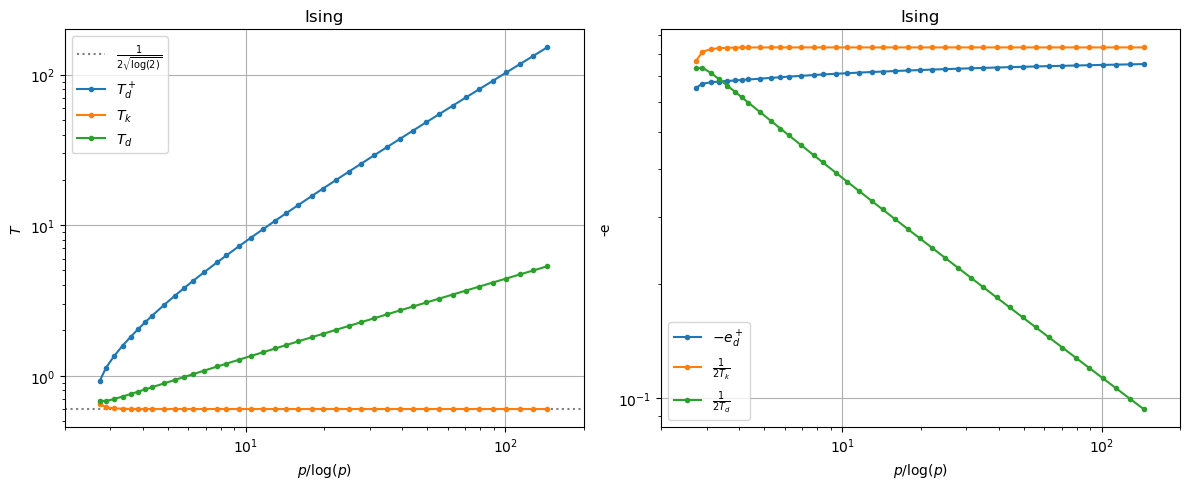

In [12]:
#xs = np.linspace(np.min(p_tab / np.log(p_tab)) +0, np.max(p_tab / np.log(p_tab)) + 0, 100)
xs = np.arange(2,200)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)

plt.plot(
    xs,
    0.5 / np.sqrt(np.log(2)) * np.ones_like(xs),
    color="k",
    linestyle=":",
    label=r"$\frac{1}{2\sqrt{\log(2)}}$",
    alpha=0.5,
)
plt.plot(
    data_Td_plus["p"] / np.log(data_Td_plus["p"]),
    data_Td_plus["T"],
    label=r"$T_d^+$",
    marker=".",
)
plt.plot(p_tab / np.log(p_tab), Tks, label=r"$T_k$", marker=".")
plt.plot(p_tab / np.log(p_tab), Tds, label=r"$T_d$", marker=".")

plt.title("Ising")
plt.xlabel("$p/ \\log(p)$")
plt.ylabel(r"$T$")
plt.legend()
plt.xlim(2,200)
plt.xscale("log")
plt.yscale("log")
plt.grid()

plt.subplot(1, 2, 2)
plt.plot(data_Td_plus["p"]/np.log(data_Td_plus["p"]), -data_Td_plus["e"], ".-", label=r"$-e_d^+$")
plt.plot(p_tab/np.log(p_tab), 1/(2*Tks), ".-", label=r"$\frac{1}{2T_k}$")
plt.plot(p_tab/np.log(p_tab), 1/(2*Tds), ".-", label=r"$\frac{1}{2T_d}$")
plt.xscale("log")
plt.yscale("log")

plt.title("Ising")
plt.xlabel("$p/ \\log(p)$")
plt.ylabel("-e")
plt.legend()
plt.xlim(2,200)

plt.grid()

plt.tight_layout()

plt.savefig("../imgs/ising_Tdplus_edplus_log.png", dpi=360)

### Plot From data

In [10]:
file_name = "../data/ising/" + "ising_Tdplus_Tk_deltaT0.00001_m01.00000_q01.00000_p3.0_1000.0_25.pkl"
with open(file_name, "rb") as f:
    data_Td_plus = pickle.load(f)

p_tab = data_Td_plus["p"]
Tds = np.empty(len(p_tab))
Tks = np.empty(len(p_tab))

for i, p in enumerate(p_tab):
    Tks[i], Tds[i] = sp_utils.get_Tk_Td(p, model="ising")

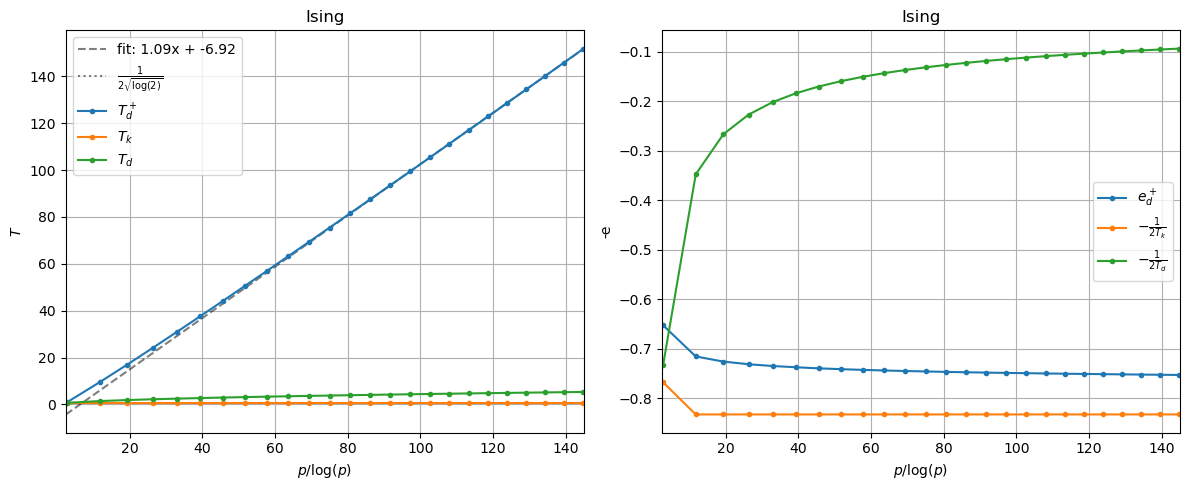

In [12]:
xs = np.linspace(np.min(p_tab / np.log(p_tab)) - 0.3, np.max(p_tab / np.log(p_tab)) + 0.3, 100)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(
    xs,
    poly_fitted(xs),
    "k--",
    label=f"fit: {poly_coeff[0]:.2f}x + {poly_coeff[1]:.2f}",
    alpha=0.5,
)
plt.plot(
    xs,
    0.5 / np.sqrt(np.log(2)) * np.ones_like(xs),
    color="k",
    linestyle=":",
    label=r"$\frac{1}{2\sqrt{\log(2)}}$",
    alpha=0.5,
)

plt.plot(
    data_Td_plus["p"] / np.log(data_Td_plus["p"]),
    data_Td_plus["T"],
    label=r"$T_d^+$",
    marker=".",
)
plt.plot(p_tab / np.log(p_tab), Tks, label=r"$T_k$", marker=".")
plt.plot(p_tab / np.log(p_tab), Tds, label=r"$T_d$", marker=".")

plt.title("Ising")
plt.xlabel("$p/ \\log(p)$")
plt.ylabel(r"$T$")
plt.legend()
plt.xlim(np.min(xs), np.max(xs))
#plt.xscale("log")
#plt.yscale("log")
plt.grid()

plt.subplot(1, 2, 2)
plt.plot(data_Td_plus["p"]/np.log(data_Td_plus["p"]), data_Td_plus["e"], ".-", label=r"$e_d^+$")
plt.plot(p_tab/np.log(p_tab), -1/(2*Tks), ".-", label=r"$-\frac{1}{2T_k}$")
plt.plot(p_tab/np.log(p_tab), -1/(2*Tds), ".-", label=r"$-\frac{1}{2T_d}$")
#plt.xscale("log")
#plt.yscale("log")

plt.title("Ising")
plt.xlabel("$p/ \\log(p)$")
plt.ylabel("-e")
plt.legend()
plt.xlim(np.min(xs), np.max(xs))

plt.grid()

plt.tight_layout()

plt.savefig("../imgs/ising_Tdplus_edplus_lin.png", dpi=360)